In [1]:
%load_ext autoreload
%autoreload 2

In [90]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import sklearn.neighbors as skln
import gc
import pickle
import os

from lshexperiment import *

DATA_DIR = 'data'
FIG_DIR = "figs"

if DATA_DIR is not None and not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
if FIG_DIR is not None and not os.path.exists(FIG_DIR):
    os.makedirs(FIG_DIR)

def save_fig(name):
    plt.savefig(os.path.join(FIG_DIR, name + ".png"), bbox_inches='tight')
    
# rng = np.random.default_rng(seed=67)
plt.rcParams["figure.figsize"] = (8,3)
plt.rcParams['figure.dpi'] = 300

## Success chance tests

In [18]:
points = np.zeros((n, d), dtype=int)

lsh = HammingLSH(points, r1, r2, delta)

In [27]:
grid = np.arange(r2 + 2)
vals = np.zeros(r2 + 2)
for dist in tqdm(grid):
    repeats = 100
    success = 0
    for j in range(repeats):
        for j in range(300):
            q = np.zeros(d, dtype=int)
            q[rng.choice(d, dist, replace=False)] = 1
            res = lsh.query(q)
            if res is None:
                success += 1
                break
    vals[dist] = success / repeats

  0%|          | 0/62 [00:00<?, ?it/s]

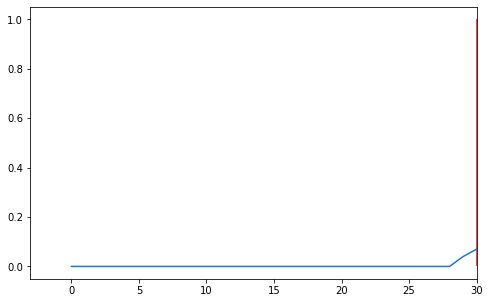

In [28]:
plt.plot(grid, vals)
plt.vlines([r1], 0, 1, colors=['red'])
plt.xlim(None, 30)
plt.show()

In [10]:
print("Success rate at r1:", vals[r1])

Success rate at r1: 1.0


# Breaking hamming LSH faster

In [91]:
env = Environment()

point_params = {
    'n': 1000,
    'd': 300,
    'point_type': "zero",
    'seed_offset': 0
}

lsh_params = {
    'delta': 1/128,
    'seed_offset': 0,
    'r1': point_params['d'] // 10,
    'r2': point_params['d'] // 5
}

exp_params = {
    'alg_type': 'adaptive',
    'iter_num': 1000,
    'seed_offset': 0,
    'target_distance': lsh_params['r1'],
}

### Analysing dependance on t

In [92]:
t_grid = np.arange(0, lsh_params['r1'] + 1, 1)
new_exp_param = exp_params.copy()
res = run_basic_grid_experiment(t_grid, 't', env, point_params, lsh_params, new_exp_param, DATA_DIR)

  0%|          | 0/31 [00:00<?, ?it/s]

In [93]:
data_succ_prob, data_queries = process_results(res)

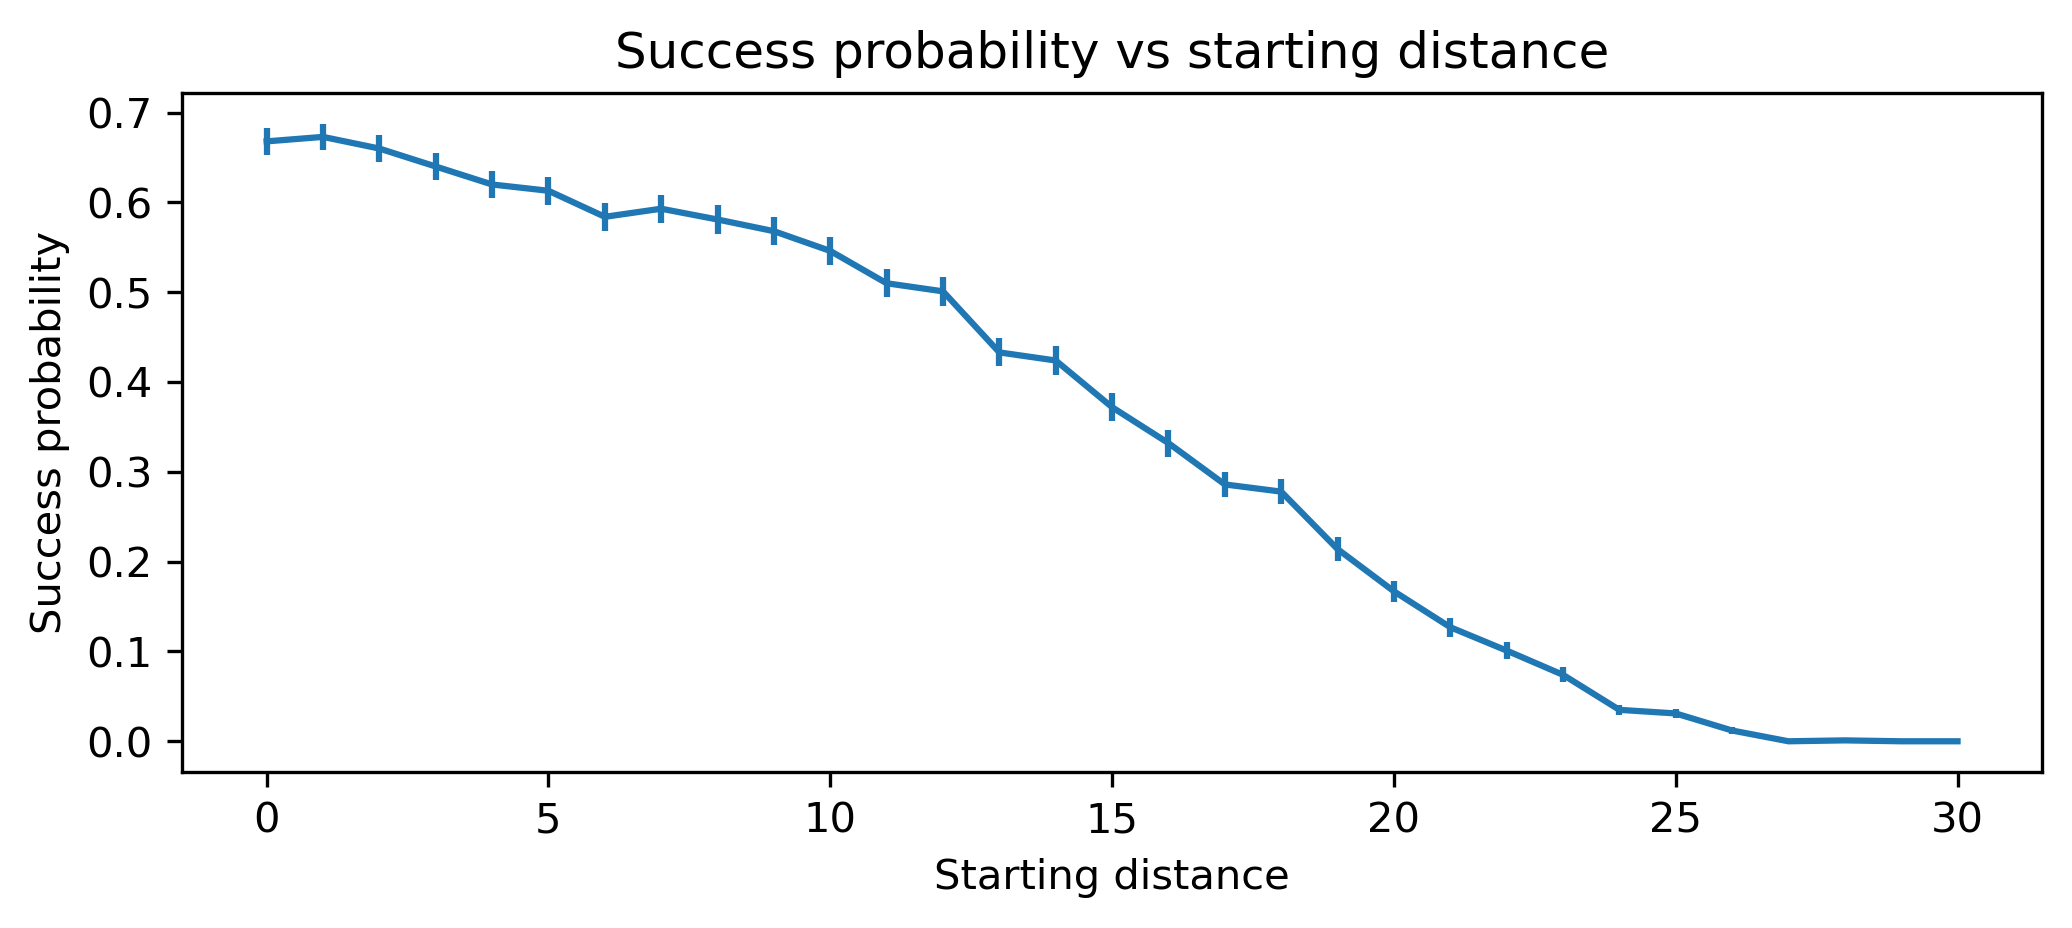

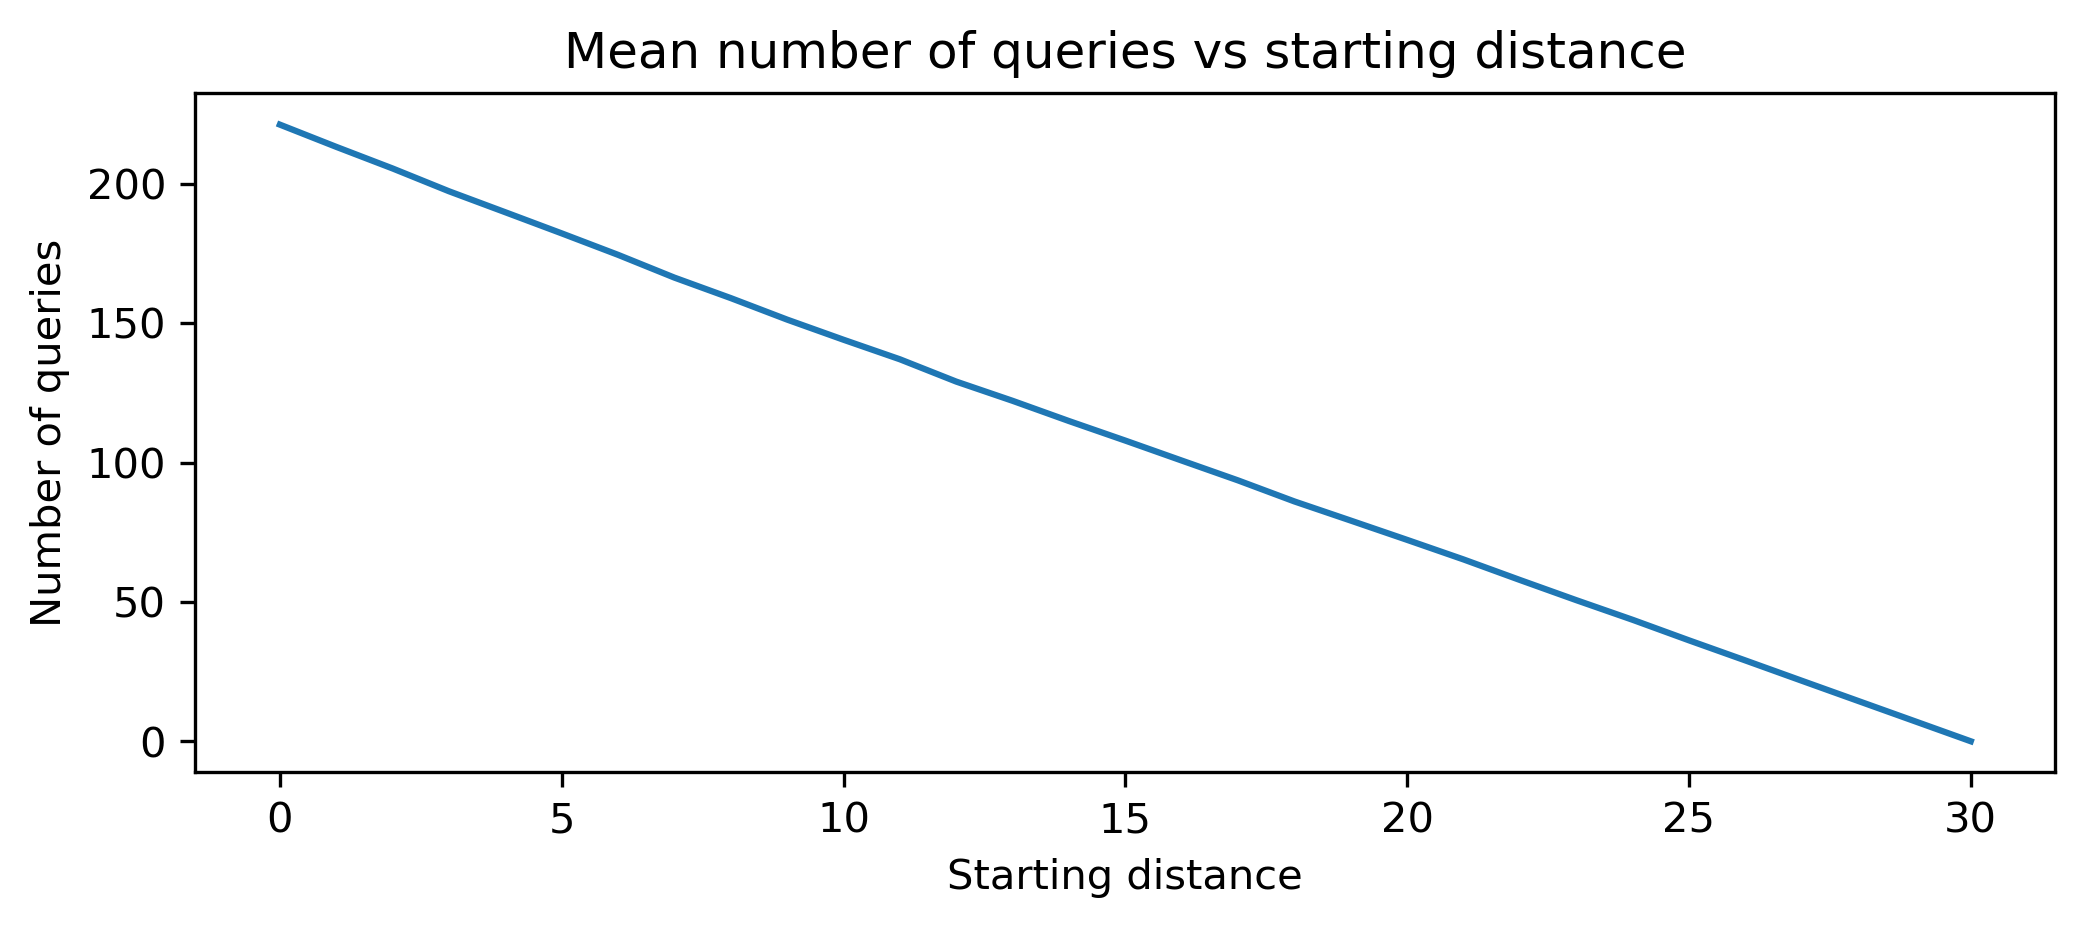

In [94]:
dist_grid = lsh_params['r1'] - t_grid
xlims = (np.min(dist_grid) - 1, np.max(dist_grid) + 1)

plt.errorbar(dist_grid, data_succ_prob[0], yerr=data_succ_prob[1])
# plt.xlim(xlims)
plt.title("Success probability vs starting distance")
plt.xlabel("Starting distance")
plt.ylabel("Success probability")
save_fig("prob-starting-distance")
plt.show()

plt.errorbar(dist_grid, data_queries[0], yerr=data_queries[1])
# plt.xlim(xlims)
plt.title("Mean number of queries vs starting distance")
plt.xlabel("Starting distance")
plt.ylabel("Number of queries")
save_fig("queries-starting-distance")
plt.show()

### Dependance on $t$ with random points

In [95]:
env = Environment()

point_params = {
    'n': 1000,
    'd': 300,
    'point_type': "random",
    'seed_offset': 0
}

lsh_params = {
    'delta': 1/128,
    'seed_offset': 0,
    'r1': point_params['d'] // 10,
    'r2': point_params['d'] // 5
}

exp_params = {
    'alg_type': 'adaptive',
    'change_points': True,
    'iter_num': 1000,
    'seed_offset': 0,
    'target_distance': lsh_params['r1'],
}

In [96]:
t_grid = np.arange(0, lsh_params['r1'] + 1, 1)
res = run_basic_grid_experiment(t_grid, 't', env, point_params, lsh_params, exp_params, data_dir=DATA_DIR)

  0%|          | 0/31 [00:00<?, ?it/s]

In [97]:
rand_data_succ_prob, rand_data_queries = process_results(res)

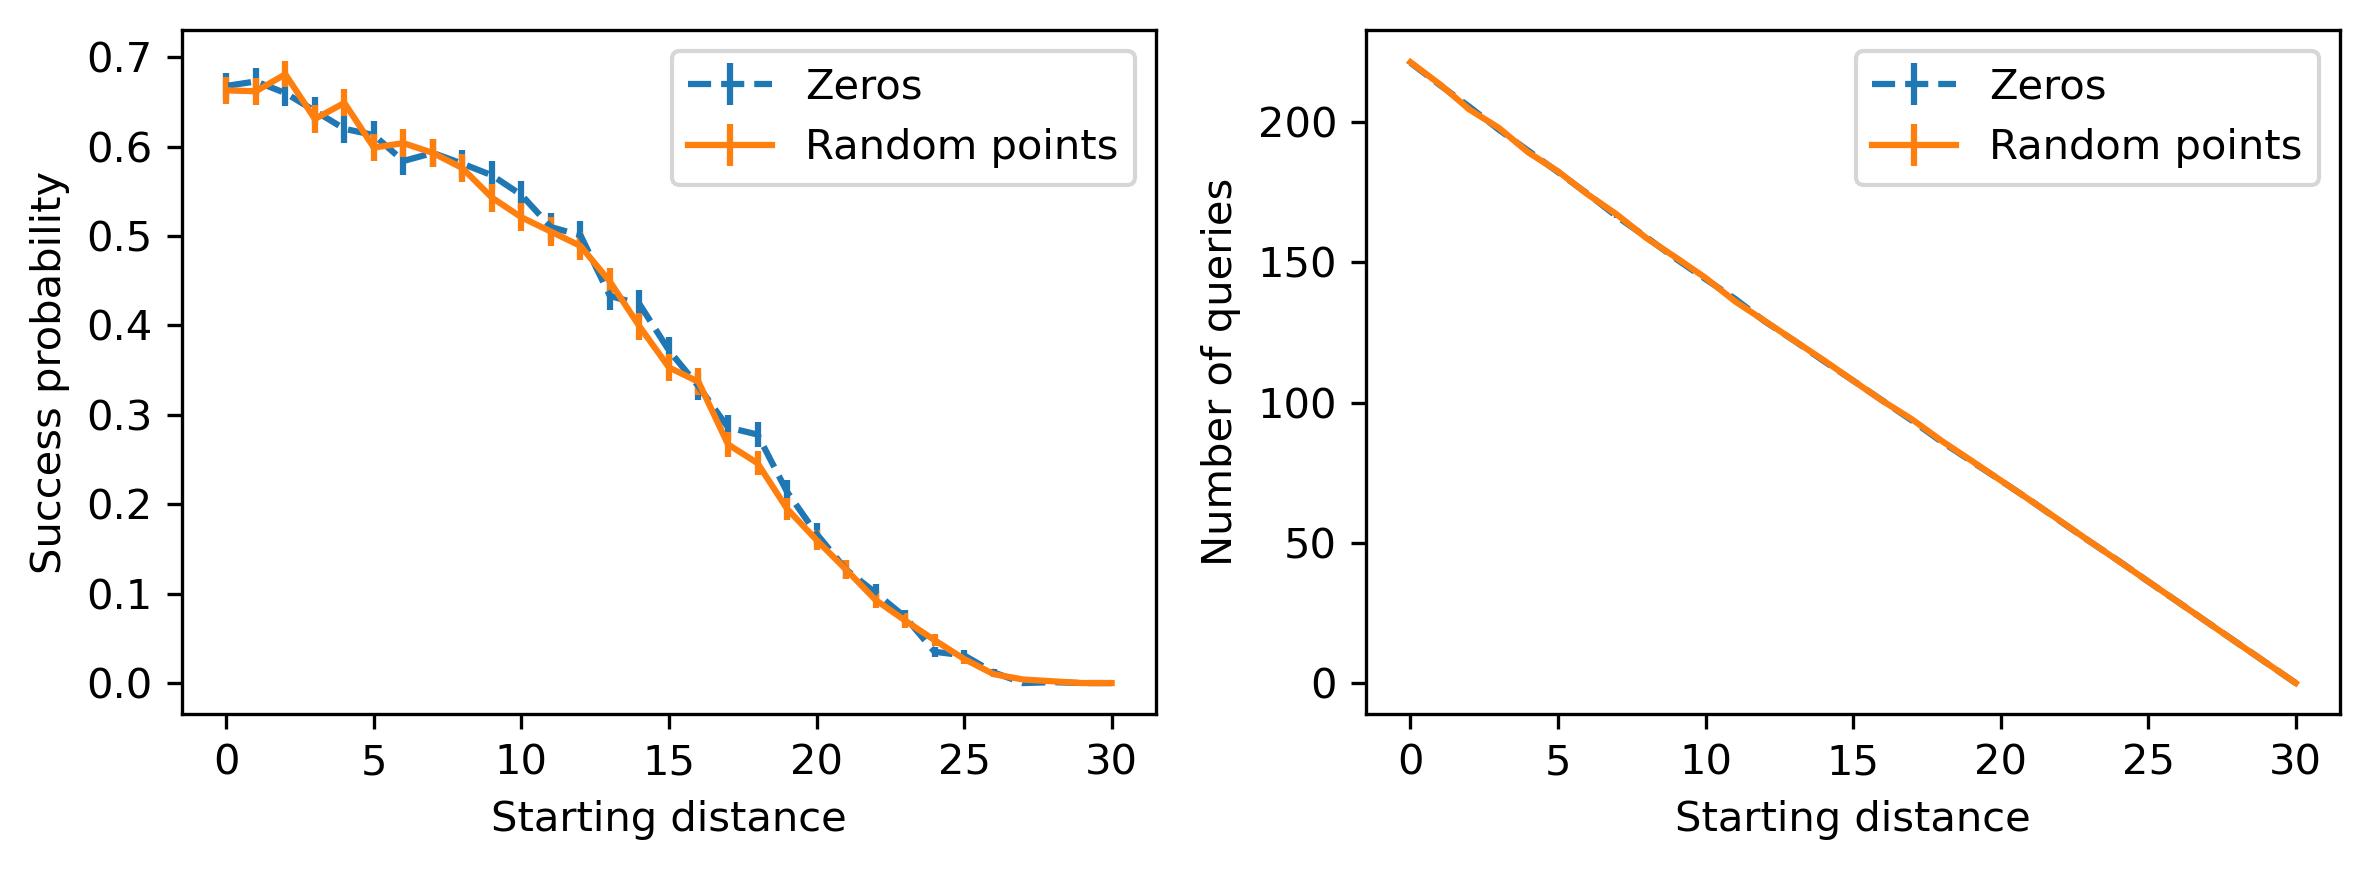

In [98]:
dist_grid = lsh_params['r1'] - t_grid
xlims = (np.min(dist_grid) - 1, np.max(dist_grid) + 1)

fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].errorbar(dist_grid, data_succ_prob[0], yerr=data_succ_prob[1], linestyle='--',label="Zeros")
axs[0].errorbar(dist_grid, rand_data_succ_prob[0], yerr=rand_data_succ_prob[1], label="Random points")
axs[0].legend()
# plt.xlim(xlims)
# plt.title("Success probability vs starting distance")
axs[0].set_xlabel("Starting distance")
axs[0].set_ylabel("Success probability")
# save_fig("all-prob-starting-distance")

axs[1].errorbar(dist_grid, data_queries[0], yerr=data_queries[1], linestyle='--', label='Zeros')
axs[1].errorbar(dist_grid, rand_data_queries[0], yerr=rand_data_queries[1], label='Random points')
axs[1].legend()
# plt.xlim(xlims)
# plt.title("Number of queries vs starting distance")
axs[1].set_xlabel("Starting distance")
axs[1].set_ylabel("Number of queries")
fig.tight_layout()
# save_fig("all-queries-starting-distance")
save_fig("all-all-starting-distance")
plt.show()

### Analysing dependance on radius

In [99]:
env = Environment()

point_params = {
    'n': 1000,
    'd': 300,
    'point_type': "zero",
    'seed_offset': 0
}

lsh_params = {
    'delta': 1/5,
    'seed_offset': 0,
    'r1': point_params['d'] // 10,
    'r2': point_params['d'] // 5
}

exp_params = {
    'alg_type': 'adaptive',
    'iter_num': 1000,
    'seed_offset': 0,
    'target_distance': lsh_params['r1'],
}

In [100]:
grid = np.arange(0, lsh_params['r1'], 1)
res = run_basic_grid_experiment(grid, 'target_distance', env, point_params, lsh_params, exp_params, data_dir=DATA_DIR)

  0%|          | 0/30 [00:00<?, ?it/s]

In [101]:
data_succ_prob, data_queries = process_results(res)

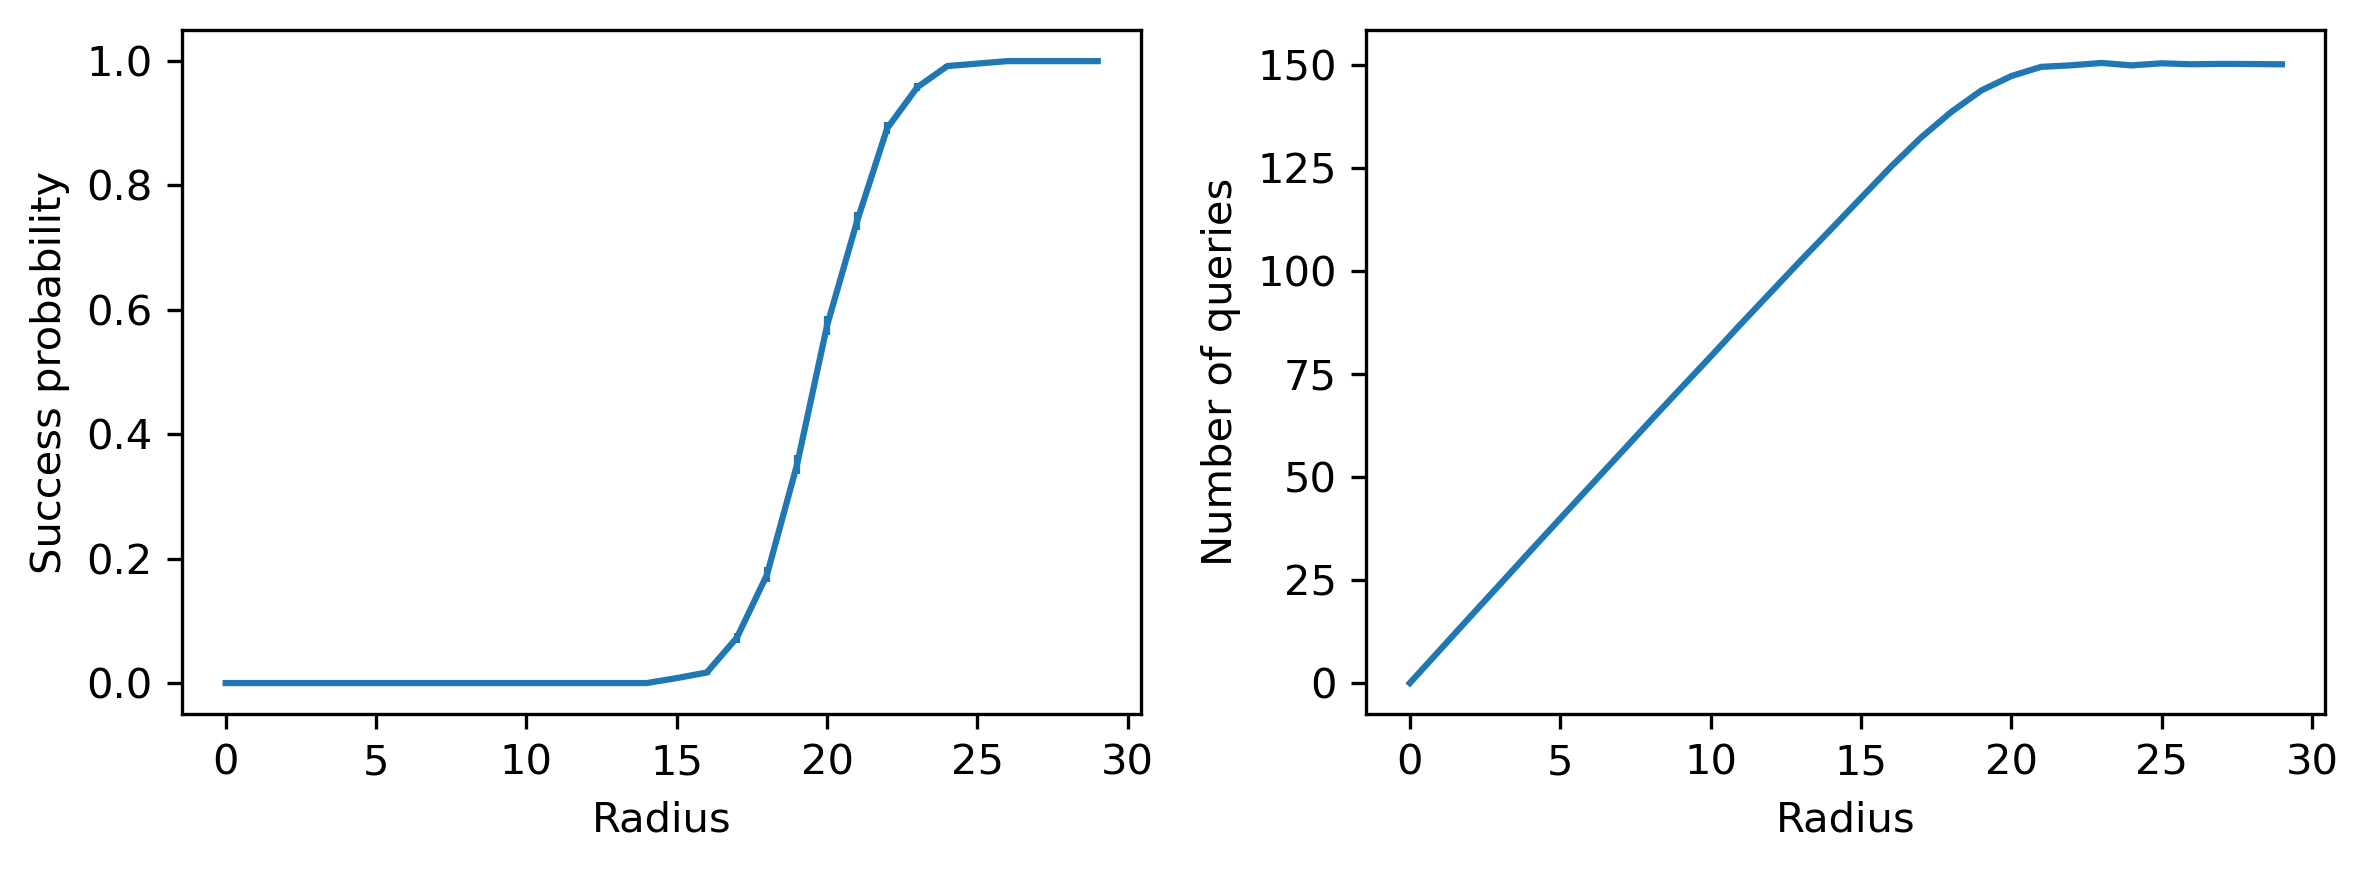

In [102]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].errorbar(grid, data_succ_prob[0], yerr=data_succ_prob[1])
# plt.xlim(xlims)
# plt.yscale("log")
axs[0].set_xlabel("Radius")
axs[0].set_ylabel("Success probability")

axs[1].errorbar(grid, data_queries[0], yerr=data_queries[1])
# plt.xlim(xlims)
axs[1].set_xlabel("Radius")
axs[1].set_ylabel("Number of queries")

fig.tight_layout()
# save_fig("all-all-starting-distance")
save_fig("all-radius")
plt.show()

### Search for infliction point

In [121]:
env = Environment()

point_params = {
    'n': 1000,
    'd': 300,
    'point_type': "zero",
    'seed_offset': 0
}

lsh_params = {
    'delta': 1/2,
    'seed_offset': 0,
    'r1': point_params['d'] // 10,
    'r2': point_params['d'] // 5
}

exp_params = {
    'alg_type': 'adaptive',
    'iter_num': 1000,
    'seed_offset': 0,
    'target_distance': lsh_params['r1'],
}

In [122]:
help_list = np.arange(1, 14, 3)
delta_list = np.exp2(-help_list)

my_rho = np.log(1 - lsh_params['r1']/point_params['d']) / np.log(1 - lsh_params['r2']/point_params['d'])
my_L = int(np.ceil(np.power(point_params['n'], my_rho)))
L_list = help_list * my_L

grid = np.arange(0, lsh_params['r2'], 1)

all_res = []

for dl in delta_list:
    new_lsh_params = lsh_params.copy()
    new_lsh_params['delta'] = dl
    res = run_basic_grid_experiment(grid, 'target_distance', env, point_params, new_lsh_params, exp_params, data_dir=DATA_DIR)
    all_res.append(res)

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

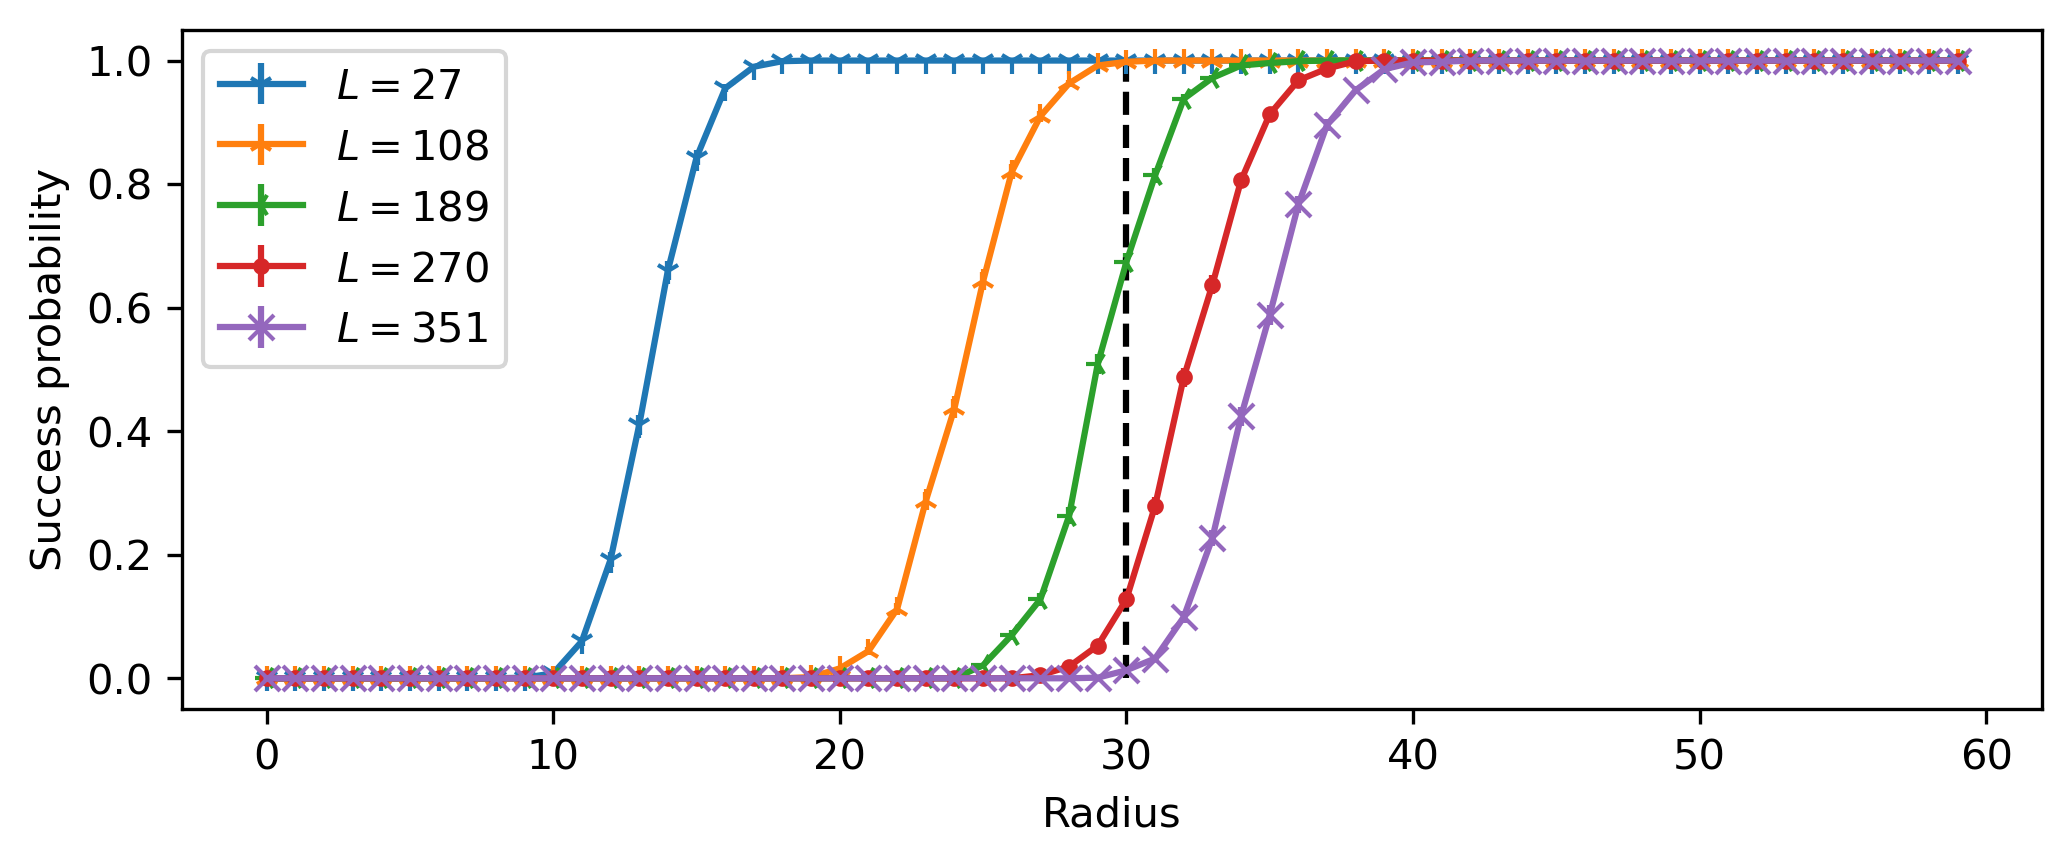

In [123]:
markers = ['1', '2', '3', '.', 'x']
for r_res, dl, mark, cl in zip(all_res, delta_list, markers, L_list):
    data_succ_prob, _ = process_results(r_res)
    plt.errorbar(grid, data_succ_prob[0], yerr=data_succ_prob[1], marker=mark, label=f"$L={cl}$")

plt.vlines(lsh_params['r1'], 0, 1, linestyles='dashed', color='black')
# plt.title(f"Success probability vs target radius")
plt.legend()
# plt.ylim(-0.1, 1.1)
plt.xlabel("Radius")
plt.ylabel("Success probability")
save_fig("delta-comparison")
plt.show()


### Success probability vs number of hash functions

In [25]:
l_list = np.linspace(1, 500, 20, endpoint=True)
points = np.zeros((n, d), dtype=int)
nn_checker = skln.KDTree(points, metric='l1')

l_all_res = []

for cur_l in tqdm(l_list):
    iters_per_point = 300
    cur_res = []
    for i in range(iters_per_point):
        lsh = HammingLSH(points, r1, r2, l=int(cur_l))
        cur_res.append(run_exp_fast(r1))
    l_all_res.append(cur_res)

  0%|          | 0/20 [00:00<?, ?it/s]

In [26]:
failure_prob = []
mean_queries = np.zeros(len(l_all_res))
err_queries = np.zeros(len(l_all_res))
# bars_queries = [np.zeros(len(r_res)), np.zeros(len(r_res))]
for i, v in enumerate(l_all_res):
    f_pr = sum(1 - e[0] for e in v) / len(v)
    failure_prob.append(f_pr)
    queries = [e[1] for e in v]
    mean_queries[i] = np.mean(queries)
#     bars_queries[0][i] = np.percentile(queries, 90)
#     bars_queries[1][i] = np.percentile(queries, 10)
    err_queries[i] = np.std(queries)


# bars_queries[0] -= mean_queries
# bars_queries[1] = mean_queries - bars_queries[1]

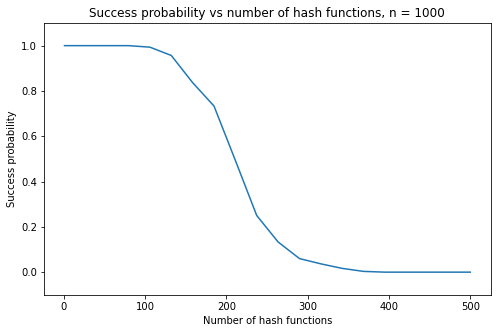

In [33]:
plt.plot(l_list, 1 - np.array(failure_prob))
plt.title(f"Success probability vs number of hash functions, n = {n}")
plt.ylim(-0.1, 1.1)
# plt.yscale("log")
# plt.xscale("log")
plt.xlabel("Number of hash functions")
plt.ylabel("Success probability")
plt.show()

### Number of queries vs $1/\delta$

In [125]:
env = Environment()

point_params = {
    'n': 1000,
    'd': 300,
    'point_type': "zero",
    'seed_offset': 0
}

lsh_params = {
    'delta': 1/2,
    'seed_offset': 0,
    'r1': point_params['d'] // 10,
    'r2': point_params['d'] // 5
}

exp_params = {
    'alg_type': 'adaptive',
    'iter_num': 1000,
    'seed_offset': 0,
    'target_distance': lsh_params['r1'],
    'max_queries': 80000,
    'max_resamples': 40000,
}

In [126]:
delta_list = np.logspace(1, 8, 8, endpoint=True, base=1/2)
my_rho = np.log(1 - lsh_params['r1']/point_params['d']) / np.log(1 - lsh_params['r2']/point_params['d'])
my_L = int(np.ceil(np.power(point_params['n'], my_rho)))
L_list = np.arange(1, 9) * my_L

delta_adapt_res = []

# for cur_delta in tqdm(delta_list):
#     iters_per_point = 100
#     cur_res = []
#     for i in range(iters_per_point):
#         lsh = HammingLSH(points, r1, r2, delta=cur_delta)
#         cur_res.append(run_exp_fast(points[0], r1, nn_checker, lsh, max_resamples=30))
#     delta_res.append(cur_res)

for dl in tqdm(delta_list):
    new_lsh_params = lsh_params.copy()
    new_lsh_params['delta'] = dl
    cur_res = run_experiments(env, point_params, new_lsh_params, exp_params, data_dir=DATA_DIR)
    delta_adapt_res.append(cur_res)

  0%|          | 0/8 [00:00<?, ?it/s]

In [127]:
delta_list = np.logspace(1, 8, 8, endpoint=True, base=1/2)
delta_rand_res = []

for dl in tqdm(delta_list):
    new_lsh_params = lsh_params.copy()
    new_lsh_params['delta'] = dl
    new_exp_params = exp_params.copy()
    new_exp_params['alg_type'] = 'random'
    cur_res = run_experiments(env, point_params, new_lsh_params, new_exp_params, data_dir=DATA_DIR)
    delta_rand_res.append(cur_res)

  0%|          | 0/8 [00:00<?, ?it/s]

In [128]:
adapt_succ_prob, adapt_queries = process_results(delta_adapt_res)
rand_succ_prob, rand_queries = process_results(delta_rand_res)

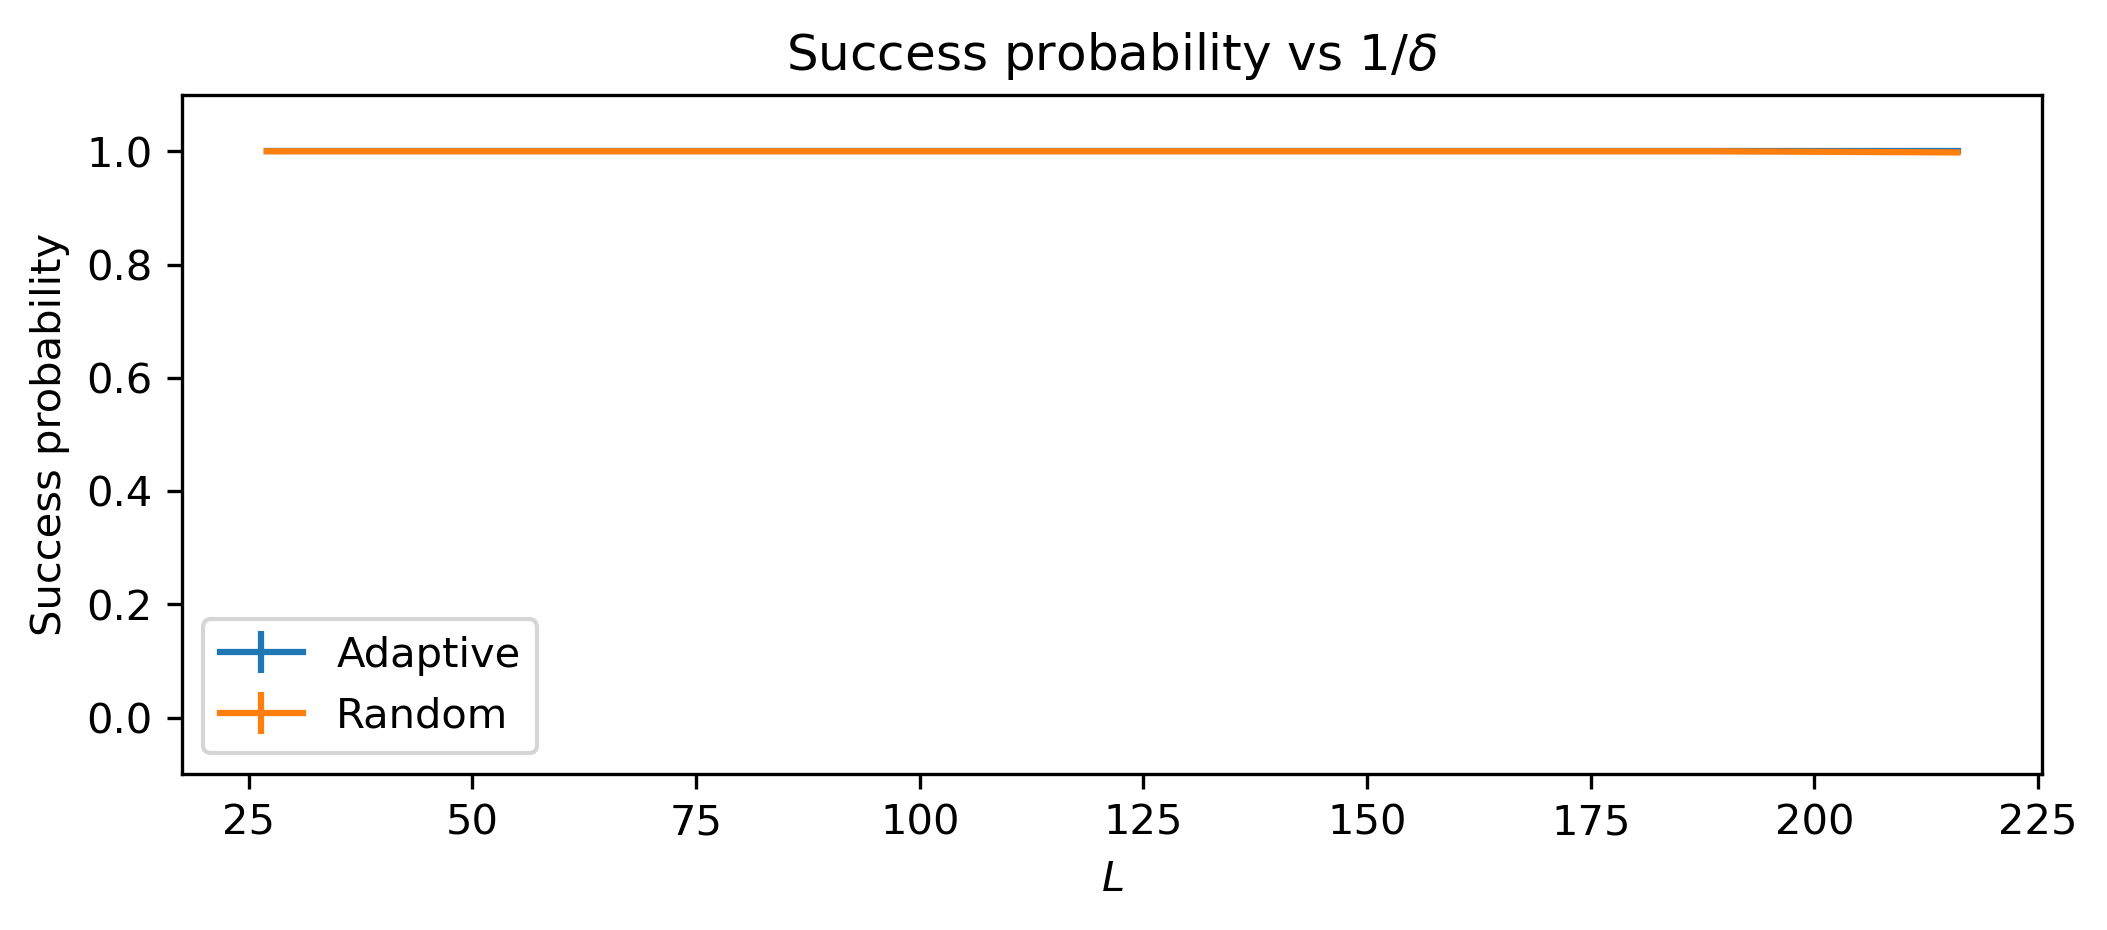

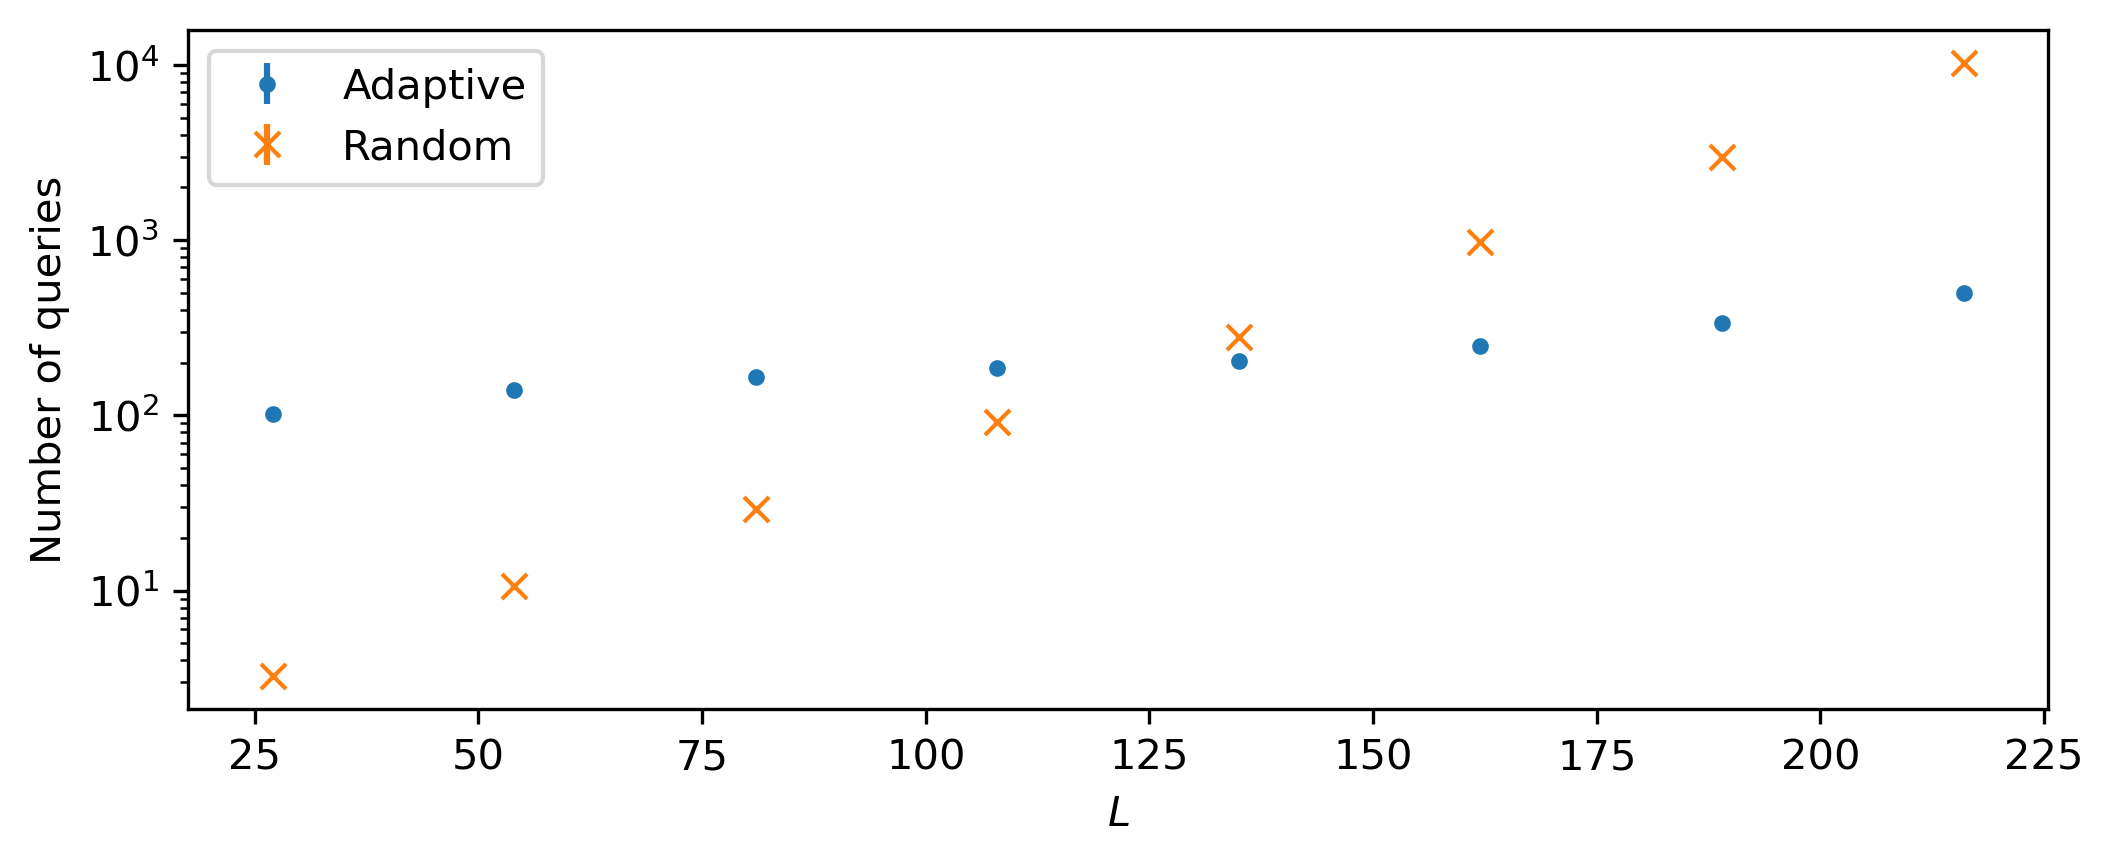

In [129]:
plt.errorbar(L_list, adapt_succ_prob[0], yerr=adapt_succ_prob[1], label="Adaptive")
plt.errorbar(L_list, rand_succ_prob[0], yerr=rand_succ_prob[1], label="Random")
plt.legend()
plt.title(f"Success probability vs $1/\delta$")
plt.ylim(-0.1, 1.1)
# plt.yscale("log")
# plt.xscale("log")
plt.xlabel("$L$")
plt.ylabel("Success probability")
plt.show()

plt.errorbar(L_list, adapt_queries[0], yerr=adapt_queries[1], label="Adaptive", marker='.', linestyle='None')
plt.errorbar(L_list, rand_queries[0], yerr=rand_queries[1], label="Random", marker='x', linestyle='None')
# plt.plot(1 / delta_list, rand_mean_queries / (1 - np.array(rand_failure_prob)), label="Random projected")
plt.legend()
# plt.title(f"Number of queries vs $1/\delta$")
plt.yscale("log")
# plt.xscale("log")
plt.xlabel("$L$")
plt.ylabel("Number of queries")
save_fig("both_queries-delta")
plt.show()

# plt.errorbar(1 / delta_list, mean_queries, yerr=err_queries, label="Adaptive")
# plt.errorbar(1 / delta_list, rand_mean_queries, yerr=rand_err_queries, label="Random")
# plt.plot(1 / delta_list, rand_mean_queries / (1 - np.array(rand_failure_prob)), label="Random projected")
# plt.legend()
# plt.title(f"Number of queries vs $1/\delta$, n = {n}")
# # plt.yscale("log")
# plt.xscale("log")
# plt.xlabel("$1 / \delta$")
# plt.ylabel("Number of queries")
# plt.show()

$X_i$ value of experiment $i$
$$1/n \cdot \sum_{i} X_i$$
error bar $$ 1/\sqrt{n} \cdot Var(X_i)$$

# Size of $G(q,z)$

In [6]:
t = 10

In [7]:
print(r1, r2, t, n, d)

30 60 10 1000 300


In [11]:
points = np.zeros((n, d))

z = np.zeros(d)

In [29]:
grid = np.arange(0, r2)

num_samples = 10
res = []
for dist in tqdm(grid):
    q = np.zeros(d)
    q[:dist] = 1
    cur_res = []
    for i in range(num_samples):
        lsh = HammingLSH(points, r1, r2, delta)
        cur_res.append(lsh.cnt_mutual_buckets(q, z))
    res.append(cur_res)

  0%|          | 0/60 [00:00<?, ?it/s]

In [40]:
frac_res = np.array(res) / lsh._l
means = np.mean(frac_res, axis=1)
err = np.std(frac_res, axis=1)

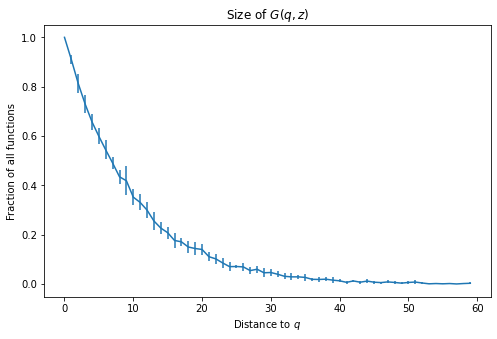

In [42]:
plt.errorbar(grid, means, yerr=err)
# plt.yscale("log")
plt.title("Size of $G(q, z)$")
plt.xlabel("Distance to $q$")
plt.ylabel("Fraction of all functions")
plt.show()

# Random points

### Analysing dependance on radius

In [148]:
env = Environment()

point_params = {
    'n': 1000,
    'd': 300,
    'point_type': "random",
    'seed_offset': 0
}

lsh_params = {
    'delta': 1/5,
    'seed_offset': 0,
    'r1': point_params['d'] // 10,
    'r2': point_params['d'] // 5
}

exp_params = {
    'alg_type': 'adaptive',
    'change_points': True,
    'iter_num': 1000,
    'seed_offset': 0,
    'target_distance': lsh_params['r1'],
}

In [ ]:
grid = np.arange(0, lsh_params['r1'], 1)
res = run_basic_grid_experiment(grid, 'target_distance', env, point_params, lsh_params, exp_params, data_dir=DATA_DIR)

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
data_succ_prob, data_queries = process_results(res)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].errorbar(grid, data_succ_prob[0], yerr=data_succ_prob[1])
# plt.xlim(xlims)
# plt.yscale("log")
axs[0].set_xlabel("Radius")
axs[0].set_ylabel("Success probability")

axs[1].errorbar(grid, data_queries[0], yerr=data_queries[1])
# plt.xlim(xlims)
axs[1].set_xlabel("Radius")
axs[1].set_ylabel("Number of queries")

fig.tight_layout()
# save_fig("all-all-starting-distance")
save_fig("all-radius-randpoint")
plt.show()

### Search for infliction point

In [ ]:
env = Environment()

point_params = {
    'n': 1000,
    'd': 300,
    'point_type': "random",
    'seed_offset': 0
}

lsh_params = {
    'delta': 1/2,
    'seed_offset': 0,
    'r1': point_params['d'] // 10,
    'r2': point_params['d'] // 5
}

exp_params = {
    'alg_type': 'adaptive',
    'change_points': True,
    'iter_num': 1000,
    'seed_offset': 0,
    'target_distance': lsh_params['r1'],
}

In [ ]:
help_list = np.arange(1, 14, 3)
delta_list = np.exp2(-help_list)

my_rho = np.log(1 - lsh_params['r1']/point_params['d']) / np.log(1 - lsh_params['r2']/point_params['d'])
my_L = int(np.ceil(np.power(point_params['n'], my_rho)))
L_list = help_list * my_L

grid = np.arange(0, lsh_params['r2'], 1)

all_res = []

for dl in delta_list:
    new_lsh_params = lsh_params.copy()
    new_lsh_params['delta'] = dl
    res = run_basic_grid_experiment(grid, 'target_distance', env, point_params, new_lsh_params, exp_params, data_dir=DATA_DIR)
    all_res.append(res)

In [ ]:
markers = ['1', '2', '3', '.', 'x']
for r_res, dl, mark, cl in zip(all_res, delta_list, markers, L_list):
    data_succ_prob, _ = process_results(r_res)
    plt.errorbar(grid, data_succ_prob[0], yerr=data_succ_prob[1], marker=mark, label=f"$L={cl}$")

plt.vlines(lsh_params['r1'], 0, 1, linestyles='dashed', color='black')
# plt.title(f"Success probability vs target radius")
plt.legend()
# plt.ylim(-0.1, 1.1)
plt.xlabel("Radius")
plt.ylabel("Success probability")
save_fig("delta-comparison-randpoint")
plt.show()


### Number of queries vs $1/\delta$

In [ ]:
env = Environment()

point_params = {
    'n': 1000,
    'd': 300,
    'point_type': "random",
    'seed_offset': 0
}

lsh_params = {
    'delta': 1/2,
    'seed_offset': 0,
    'r1': point_params['d'] // 10,
    'r2': point_params['d'] // 5
}

exp_params = {
    'alg_type': 'adaptive',
    'change_points': True,
    'iter_num': 1000,
    'seed_offset': 0,
    'target_distance': lsh_params['r1'],
    'max_queries': 80000,
    'max_resamples': 40000,
}

In [ ]:
delta_list = np.logspace(1, 8, 8, endpoint=True, base=1/2)
my_rho = np.log(1 - lsh_params['r1']/point_params['d']) / np.log(1 - lsh_params['r2']/point_params['d'])
my_L = int(np.ceil(np.power(point_params['n'], my_rho)))
L_list = np.arange(1, 9) * my_L

delta_adapt_res = []

# for cur_delta in tqdm(delta_list):
#     iters_per_point = 100
#     cur_res = []
#     for i in range(iters_per_point):
#         lsh = HammingLSH(points, r1, r2, delta=cur_delta)
#         cur_res.append(run_exp_fast(points[0], r1, nn_checker, lsh, max_resamples=30))
#     delta_res.append(cur_res)

for dl in tqdm(delta_list):
    new_lsh_params = lsh_params.copy()
    new_lsh_params['delta'] = dl
    cur_res = run_experiments(env, point_params, new_lsh_params, exp_params, data_dir=DATA_DIR)
    delta_adapt_res.append(cur_res)

In [ ]:
delta_list = np.logspace(1, 8, 8, endpoint=True, base=1/2)
delta_rand_res = []

for dl in tqdm(delta_list):
    new_lsh_params = lsh_params.copy()
    new_lsh_params['delta'] = dl
    new_exp_params = exp_params.copy()
    new_exp_params['alg_type'] = 'random'
    cur_res = run_experiments(env, point_params, new_lsh_params, new_exp_params, data_dir=DATA_DIR)
    delta_rand_res.append(cur_res)

In [ ]:
adapt_succ_prob, adapt_queries = process_results(delta_adapt_res)
rand_succ_prob, rand_queries = process_results(delta_rand_res)

In [ ]:
plt.errorbar(L_list, adapt_succ_prob[0], yerr=adapt_succ_prob[1], label="Adaptive")
plt.errorbar(L_list, rand_succ_prob[0], yerr=rand_succ_prob[1], label="Random")
plt.legend()
plt.title(f"Success probability vs $1/\delta$")
plt.ylim(-0.1, 1.1)
# plt.yscale("log")
# plt.xscale("log")
plt.xlabel("$L$")
plt.ylabel("Success probability")
plt.show()

plt.errorbar(L_list, adapt_queries[0], yerr=adapt_queries[1], label="Adaptive", marker='.', linestyle='None')
plt.errorbar(L_list, rand_queries[0], yerr=rand_queries[1], label="Random", marker='x', linestyle='None')
# plt.plot(1 / delta_list, rand_mean_queries / (1 - np.array(rand_failure_prob)), label="Random projected")
plt.legend()
# plt.title(f"Number of queries vs $1/\delta$")
plt.yscale("log")
# plt.xscale("log")
plt.xlabel("$L$")
plt.ylabel("Number of queries")
save_fig("both_queries-delta-randpoint")
plt.show()

# plt.errorbar(1 / delta_list, mean_queries, yerr=err_queries, label="Adaptive")
# plt.errorbar(1 / delta_list, rand_mean_queries, yerr=rand_err_queries, label="Random")
# plt.plot(1 / delta_list, rand_mean_queries / (1 - np.array(rand_failure_prob)), label="Random projected")
# plt.legend()
# plt.title(f"Number of queries vs $1/\delta$, n = {n}")
# # plt.yscale("log")
# plt.xscale("log")
# plt.xlabel("$1 / \delta$")
# plt.ylabel("Number of queries")
# plt.show()